# NDE

In [604]:
import pandas as pd

In [605]:
df = pd.read_csv("aegypti.csv")

In [606]:
brazil_df = df[df["COUNTRY"] == "Brazil"]

In [607]:
brazil_df.head()
brazil_df.reset_index(drop = True , inplace = True)

In [608]:
brazil_df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,YEAR,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS
0,Aedes aegypti,402,unpublished,polygon,2,-32.21,-52.38,2013.0,Brazil,BRA,37,NaN
1,Aedes aegypti,403,unpublished,polygon,2,-31.56,-52.31,2013.0,Brazil,BRA,37,NaN
2,Aedes aegypti,404,unpublished,polygon,2,-30.80,-55.63,2013.0,Brazil,BRA,37,NaN
3,Aedes aegypti,405,unpublished,polygon,2,-30.37,-51.32,2013.0,Brazil,BRA,37,NaN
4,Aedes aegypti,406,unpublished,polygon,2,-30.34,-54.37,2013.0,Brazil,BRA,37,NaN


In [609]:
df_ = brazil_df.loc[:, ['Y','X','LOCATION_TYPE']]
df_['presence'] = 1

In [610]:
import numpy as np

In [611]:
sparsity_fraction = 0.3
# np.random.seed(42)
df_clone = df_.copy()

In [612]:
mask =  np.random.rand(df_.shape[0]) < sparsity_fraction

In [613]:
str_mask = [str(i) for i in mask]

In [614]:
df_clone['PRES'] = str_mask

In [615]:
def map_presence(val):
    if val == 'True':
        return np.nan
    elif val == 'False':
        return 1

In [616]:
df_clone['presence'] = df_clone['PRES'].apply(map_presence)

In [617]:
presence_data = df_clone[df_clone['presence'].notna()]
presence_data.reset_index(drop=True, inplace=True)

nodata = df_clone[df_clone['presence'].isnull()]
nodata.reset_index(drop=True, inplace=True)

In [132]:
pip install nflows


Note: you may need to restart the kernel to use updated packages.


# Split

In [543]:
import torch
from torch.utils.data import DataLoader, TensorDataset

features = presence_data[["X", "Y"]].values
X = torch.tensor(features, dtype=torch.float32)

dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)


In [134]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow

def create_flow(input_dim=2, hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))
    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)

flow = create_flow(input_dim=X.shape[1])


In [135]:
import torch
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation  as Reverse
from nflows.flows.base import Flow
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_

In [136]:
from nflows.transforms.permutations import RandomPermutation

# Architecture of the flow

In [137]:
def create_flow(input_dim=2, hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))

        transforms.append(Reverse(features=input_dim))

    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))
        transforms.append(Reverse(features=input_dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)



In [138]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


flow = create_flow(input_dim=X.shape[1])

Using device: cpu


In [139]:
# Optimizer
optimizer = Adam(flow.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

def train_nf(flow, dataset, optimizer, n_epochs=50, device=device):
    flow.train()
    for epoch in range(n_epochs):
        total_loss = 0
        num_batches = 0
        for batch in dataset:
            batch_data = batch[0].to(device)

            optimizer.zero_grad()
            loss = -flow.log_prob(batch_data).mean()

            loss.backward()
            clip_grad_norm_(flow.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        scheduler.step()

        print(f"Epoch {epoch+1}, Loss: {total_loss / num_batches:.4f}")


In [140]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.normalization import BatchNorm
from nflows.flows.base import Flow

In [141]:
import torch

# Training

In [142]:

train_nf(flow, dataset, optimizer, n_epochs=100, device=device)

Epoch 1, Loss: 51.8635
Epoch 2, Loss: 15.7656
Epoch 3, Loss: 11.6254
Epoch 4, Loss: 11.2601
Epoch 5, Loss: 9.8030
Epoch 6, Loss: 8.7851
Epoch 7, Loss: 8.2399
Epoch 8, Loss: 8.9032
Epoch 9, Loss: 8.0445
Epoch 10, Loss: 7.5266
Epoch 11, Loss: 8.0024
Epoch 12, Loss: 7.4618
Epoch 13, Loss: 7.3751
Epoch 14, Loss: 7.9422
Epoch 15, Loss: 7.7289
Epoch 16, Loss: 7.4540
Epoch 17, Loss: 6.9712
Epoch 18, Loss: 9.6124
Epoch 19, Loss: 7.2674
Epoch 20, Loss: 7.1771
Epoch 21, Loss: 7.3007
Epoch 22, Loss: 7.2103
Epoch 23, Loss: 6.9806
Epoch 24, Loss: 7.8465
Epoch 25, Loss: 7.3538
Epoch 26, Loss: 7.3583
Epoch 27, Loss: 7.1978
Epoch 28, Loss: 7.6152
Epoch 29, Loss: 7.4289
Epoch 30, Loss: 6.8821
Epoch 31, Loss: 7.4944
Epoch 32, Loss: 6.8397
Epoch 33, Loss: 7.0963
Epoch 34, Loss: 6.6648
Epoch 35, Loss: 6.7889
Epoch 36, Loss: 6.5780
Epoch 37, Loss: 6.5308
Epoch 38, Loss: 7.1778
Epoch 39, Loss: 6.7504
Epoch 40, Loss: 6.5242
Epoch 41, Loss: 6.6920
Epoch 42, Loss: 6.4004
Epoch 43, Loss: 6.3877
Epoch 44, Loss: 

C:\Users\dzaik\AppData\Local\Temp\ipykernel_38956\3715488545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodata["nde_prediction"] = probs


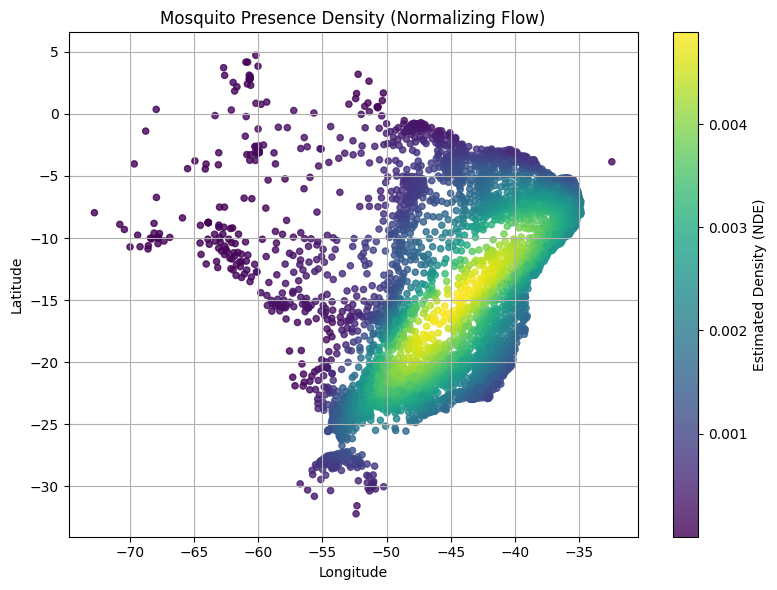

In [143]:
nodata_coords = torch.tensor(nodata[["X", "Y"]].values, dtype=torch.float32)
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(nodata_coords)
    probs = torch.exp(log_probs).numpy()
    nodata["nde_prediction"] = probs

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    nodata["X"], nodata["Y"],
    c=nodata["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

Device Management (GPU support): For any non-trivial dataset or model size, training on a GPU is essential. Move the flow model to the device (flow.to(device)). Move each batch of data to the device (batch.to(device)).

Permutations/Reversals: While MAATs can theoretically learn complex transformations, stacking identical MAATs without explicit permutations between them might limit the model's expressiveness or require more layers. A common practice is to include a permutation layer (like nflows.transforms.permutations.Reverse or a learned permutation) between autoregressive layers. This shuffles the feature dimensions, ensuring that dependencies learned in one layer are presented in a different order to the next layer.



In [144]:
pseudo_df = pd.read_csv("pseudo_data.csv")

In [145]:
pseudo_df.head()

,X,Y,LOCATION_TYPE
0,-52.38,-32.21,presence
1,-52.31,-31.56,presence
2,-55.63,-30.80,presence
3,-51.32,-30.37,presence
4,-54.37,-30.34,presence


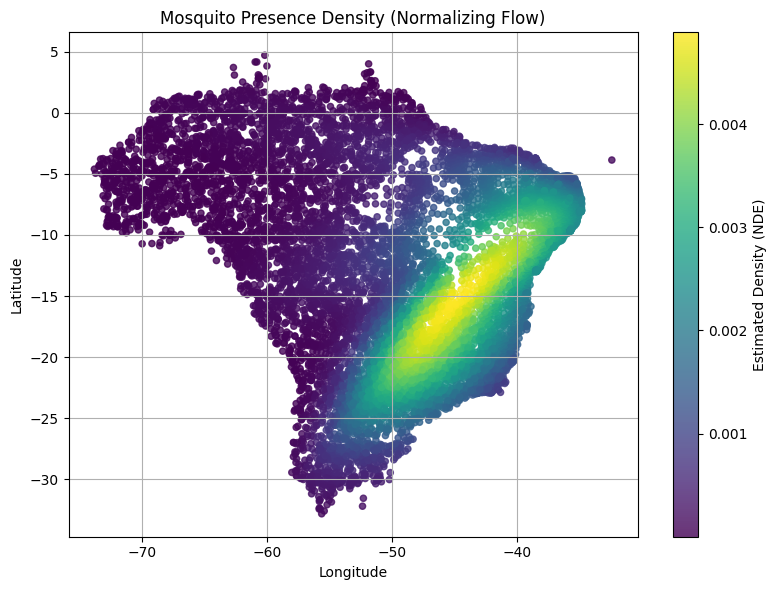

In [146]:
pseudo_coords = torch.tensor(pseudo_df[["X", "Y"]].values, dtype=torch.float32)
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(pseudo_coords)
    probs = torch.exp(log_probs).numpy()
    pseudo_df["nde_prediction"] = probs

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pseudo_df["X"], pseudo_df["Y"],
    c=pseudo_df["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [147]:
import numpy as np

def boyce_index(pred_presence, pred_background, num_bins=10):
    """
    Compute the continuous Boyce Index.

    Args:
        pred_presence: array-like, predicted densities at true presence locations
        pred_background: array-like, predicted densities at background (nodata) locations
        num_bins: number of bins to group predicted values

    Returns:
        Boyce Index value (Spearman correlation between bin ranks and ratio of presence to background counts)
    """
    # Create bin edges between min and max of background predictions
    bins = np.linspace(pred_background.min(), pred_background.max(), num_bins + 1)

    # Count how many presence and background points fall into each bin
    pres_counts, _ = np.histogram(pred_presence, bins=bins)
    back_counts, _ = np.histogram(pred_background, bins=bins)

    # Calculate ratio: presence / background per bin (avoid divide-by-zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = pres_counts / back_counts
        valid = back_counts > 0
        ratio = ratio[valid]
        bin_ranks = np.arange(len(ratio))

    # Return Spearman correlation if we have at least 2 bins
    if len(ratio) >= 2:
        return np.corrcoef(bin_ranks, ratio)[0, 1]
    else:
        return np.nan


In [148]:
pseudo_df['LOCATION_TYPE'].unique()

array(['presence', 'absense'], dtype=object)

In [149]:
background_df = pseudo_df[pseudo_df['LOCATION_TYPE'] == 'absense']
background_df.reset_index(drop=True, inplace=True)

In [150]:
background_df

,X,Y,LOCATION_TYPE,nde_prediction
0,-51.340323,-21.294093,absense,0.002924
1,-53.815449,-4.460193,absense,0.000303
2,-53.412585,-21.224285,absense,0.001118
3,-46.676435,-19.531162,absense,0.004234
4,-66.217836,-5.086973,absense,0.000006
...,...,...,...,...
4995,-64.510023,-0.473182,absense,0.000084
4996,-45.037822,-21.059833,absense,0.002863
4997,-57.901437,-1.709239,absense,0.000206
4998,-50.088505,-10.347747,absense,0.001088


In [ ]:
import torch
import numpy as np

# --- Define Boyce Index function (NumPy-based) ---
def boyce_index(pred_presence, pred_background, num_bins=10):
    """
    Compute the continuous Boyce Index.

    Args:
        pred_presence: array-like, predicted densities at presence locations
        pred_background: array-like, predicted densities at background locations
        num_bins: number of bins to group predicted values

    Returns:
        Boyce Index value (Spearman correlation)
    """
    bins = np.linspace(pred_background.min(), pred_background.max(), num_bins + 1)

    pres_counts, _ = np.histogram(pred_presence, bins=bins)
    back_counts, _ = np.histogram(pred_background, bins=bins)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = pres_counts / back_counts
        valid = back_counts > 0
        ratio = ratio[valid]
        bin_ranks = np.arange(len(ratio))

    if len(ratio) >= 2:
        return np.corrcoef(bin_ranks, ratio)[0, 1]
    else:
        return np.nan



# Convert coordinates to torch tensors
presence_tensor = torch.tensor(presence_data[["X", "Y"]].values, dtype=torch.float32).to(device)
background_tensor = torch.tensor(background_df[["X", "Y"]].values, dtype=torch.float32).to(device)

# Get log probabilities (densities) from the flow
flow.eval()  
with torch.no_grad():
    log_probs_presence = flow.log_prob(presence_tensor)
    log_probs_background = flow.log_prob(background_tensor)

# Convert log-probs to densities
pred_presence = torch.exp(log_probs_presence)
pred_background = torch.exp(log_probs_background)

# Convert to numpy
pred_presence_np = pred_presence.cpu().numpy()
pred_background_np = pred_background.cpu().numpy()

# Compute Boyce Index
boyce = boyce_index(pred_presence_np, pred_background_np)
print(f"Boyce Index (NDE): {boyce:.4f}")


Boyce Index (NDE): 0.4436


In [153]:
df = pd.read_csv("aegypti.csv")

In [154]:
african_countries = [
    'Nigeria', 'Congo', 'Democratic Republic of the Congo', 'Central African Republic',
    'Cameroon', 'Madagascar', 'Gabon', 'Mayotte', 'R?union', 'Comoros', 'Senegal',
    'Kenya', 'Uganda', 'Sudan', 'Zambia', 'Ghana', 'Burkina Faso', 'Guinea',
    'United Republic of Tanzania', 'Gambia', 'South Africa', 'Mozambique', 'Somalia',
    'Djibouti', 'Zimbabwe', 'Angola', 'Sierra Leone', 'Benin', 'Liberia'
]


In [155]:

africa_df = df[df['COUNTRY'].isin(african_countries)]


In [156]:
presence_points = africa_df[['X', 'Y']].to_numpy()


In [157]:
latitudes = africa_df['Y']
longitudes = africa_df['X']

In [158]:
nodata_coords.shape

torch.Size([4544, 2])

In [159]:
presence_points.T.shape

(2, 546)

In [160]:
africa_df.reset_index(drop=True, inplace=True)

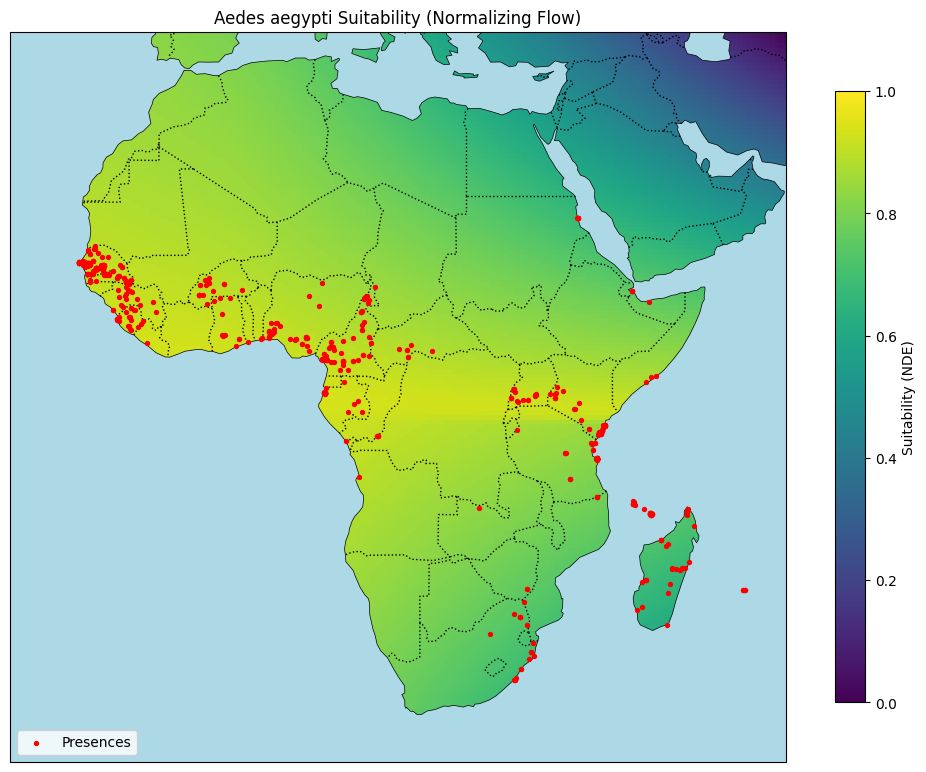

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lon_vals = np.linspace(-25, 60, 170)     
lat_vals = np.linspace(-40, 40, 160)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
grid_pts = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T


with torch.no_grad():
    t = torch.tensor(grid_pts, dtype=torch.float32)       
    logp = flow.log_prob(t).cpu().numpy()                 


suit = (logp - logp.min()) / (logp.max() - logp.min())
suit = suit.reshape(lon_grid.shape)                       
fig = plt.figure(figsize=(10, 8))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

mesh = ax.pcolormesh(
    lon_grid,
    lat_grid,
    suit,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto",
    zorder=1,
)


ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=3)
cbar = fig.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.8)
cbar.set_label("Suitability (NDE)")

ax.scatter(
    africa_df["X"], 
    africa_df["Y"],
    color="red",
    s=8,
    transform=ccrs.PlateCarree(),
    label="Presences",
    zorder=4
)

ax.set_title("Aedes aegypti Suitability (Normalizing Flow)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


# COVARIATES

In [618]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [619]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [620]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df_clone,
    geometry=gpd.points_from_xy(df_clone['X'], df_clone['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values


In [621]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(5057, 3)


In [622]:
gdf.head()

,Y,X,LOCATION_TYPE,presence,PRES,geometry,water_occurrence
0,-32.21,-52.38,polygon,NaN,True,POINT (-52.38 -32.21),16.0
1,-31.56,-52.31,polygon,1.0,False,POINT (-52.31 -31.56),28.0
2,-30.80,-55.63,polygon,1.0,False,POINT (-55.63 -30.8),3.0
3,-30.37,-51.32,polygon,1.0,False,POINT (-51.32 -30.37),62.0
4,-30.34,-54.37,polygon,1.0,False,POINT (-54.37 -30.34),16.0


In [623]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       Y      X LOCATION_TYPE  presence   PRES  water_occurrence
0 -32.21 -52.38       polygon       NaN   True              16.0
1 -31.56 -52.31       polygon       1.0  False              28.0
2 -30.80 -55.63       polygon       1.0  False               3.0
3 -30.37 -51.32       polygon       1.0  False              62.0
4 -30.34 -54.37       polygon       1.0  False              16.0


In [624]:
brazil_data_with_water.shape

(5057, 6)

In [625]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

In [626]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [627]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [628]:
new_brazil_data.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666


In [629]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [630]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [631]:
brazil_data_with_eath.shape

(5057, 8)

In [632]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [633]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [634]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0


In [635]:
brazil_data_with_crop_mask.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666,0.0,9.0,2.771853,102.0


In [636]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [637]:

new_brazil_data_cov.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666


In [638]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [639]:
brazil_data_with_precip.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [640]:
presence_data = brazil_data_with_precip[brazil_data_with_precip["presence"].notna()]
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]


In [641]:
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]

In [642]:
nodata.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
8,-30.10,-51.16,polygon,NaN,True,11.0,19.633333,0.0,0.0,200.926620,144.0,4.426367
12,-29.92,-51.18,polygon,NaN,True,21.0,20.808334,69.0,0.0,6156.799805,20.0,4.460515
16,-29.73,-51.06,polygon,NaN,True,0.0,19.848333,0.0,1.0,31.515226,23.0,4.504791
20,-29.46,-50.16,polygon,NaN,True,0.0,17.868334,0.0,0.0,10.877942,708.0,6.751092


In [643]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,1.0,False,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065


In [644]:
nodata = nodata.drop("PRES", axis=1)

In [645]:
nodata.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
8,-30.10,-51.16,polygon,NaN,11.0,19.633333,0.0,0.0,200.926620,144.0,4.426367
12,-29.92,-51.18,polygon,NaN,21.0,20.808334,69.0,0.0,6156.799805,20.0,4.460515
16,-29.73,-51.06,polygon,NaN,0.0,19.848333,0.0,1.0,31.515226,23.0,4.504791
20,-29.46,-50.16,polygon,NaN,0.0,17.868334,0.0,0.0,10.877942,708.0,6.751092


In [646]:
presence_data = presence_data.drop("PRES", axis=1)

In [647]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
1,-31.56,-52.31,polygon,1.0,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-30.34,-54.37,polygon,1.0,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,1.0,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065


In [648]:
nodata.fillna(0)

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,0.0,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
8,-30.10,-51.16,polygon,0.0,11.0,19.633333,0.0,0.0,200.926620,144.0,4.426367
12,-29.92,-51.18,polygon,0.0,21.0,20.808334,69.0,0.0,6156.799805,20.0,4.460515
16,-29.73,-51.06,polygon,0.0,0.0,19.848333,0.0,1.0,31.515226,23.0,4.504791
20,-29.46,-50.16,polygon,0.0,0.0,17.868334,0.0,0.0,10.877942,708.0,6.751092
...,...,...,...,...,...,...,...,...,...,...,...
5048,-22.80,-43.41,point,0.0,0.0,25.426666,100.0,0.0,16283.635742,16.0,3.990509
5049,-22.78,-43.30,point,0.0,0.0,25.408333,100.0,0.0,18494.919922,11.0,2.731070
5052,-2.41,-48.15,point,0.0,48.0,27.146667,13.0,0.0,1740.925415,23.0,6.506164
5053,-2.58,-51.91,point,0.0,6.0,26.966667,0.0,0.0,1.384313,52.0,5.690430


In [649]:

feature_cols = ["X", "Y"] + [
    "water_occurrence",
    "annual_mean_temp",
    "urban_built_up_eartnev",
    "croplands",
    "pop_density",
    "crop_mask",
    "precipitation_mean"
]


presence_data = presence_data[feature_cols].values
X = torch.tensor(presence_data, dtype=torch.float32)  


dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)
flow = create_flow(input_dim=X.shape[1], hidden_features=64, num_layers=5).to(device)


In [650]:
X.shape[1]

9

In [651]:
import numpy as np

print("Any NaNs?", np.isnan(presence_data).any())
print("Any Infs?", np.isinf(presence_data).any())


Any NaNs? False
Any Infs? False


In [652]:
type(presence_data)


numpy.ndarray

In [653]:
import numpy as np

# Check for nan or infinite values in presence_data
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)  # Replace with reasonable defaults

In [654]:
X = torch.tensor(presence_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)

# Splitting

In [655]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

feature_cols = ["X", "Y"] + [

    "pop_density",
    "precipitation_mean",
    "water_occurence"
]

# Split into target and covariate columns
covariate_cols = ["pop_density",
    "precipitation_mean", "water_occurence"]
target_cols = [col for col in feature_cols if col not in covariate_cols]

target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]
target_data = presence_data[:, target_indices]
covariate_data = presence_data[:, covariate_indices]

# Normalize the data
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)
covariate_data = scaler.fit_transform(covariate_data)

# Convert to tensors
X_target = torch.tensor(target_data, dtype=torch.float32)
X_covariate = torch.tensor(covariate_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X_target, X_covariate), batch_size=128, shuffle=True)

In [656]:
pip install --upgrade nflows

Note: you may need to restart the kernel to use updated packages.


In [657]:
import inspect
from nflows.flows.base import Flow
print(inspect.signature(Flow.log_prob))

(self, inputs, context=None)


# NDE TRAINING WITH COVARIATES

In [658]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from sklearn.preprocessing import StandardScaler
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.normalization import BatchNorm
from nflows.flows.base import Flow

class ConditionalMaskedAffineAutoregressiveTransform(MaskedAffineAutoregressiveTransform):
    def __init__(self, features, hidden_features, context_features, num_blocks=2, use_residual_blocks=True, random_mask=False):
        super().__init__(features=features, hidden_features=hidden_features, num_blocks=num_blocks,
                        use_residual_blocks=use_residual_blocks, random_mask=random_mask)
        self.context_features = context_features
        # Context encoder to process covariates
        self.context_net = nn.Sequential(
            nn.Linear(context_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, features * 2)  
        )

    def forward(self, inputs, context=None, **kwargs):
        if context is None:
            return super().forward(inputs, **kwargs)
    
        context_params = self.context_net(context)
        shift, log_scale = context_params.chunk(2, dim=-1)
        scale = torch.sigmoid(log_scale + 2.)  

       
        outputs, logabsdet = super().forward(inputs, **kwargs)
        outputs = outputs + shift
        logabsdet = logabsdet + torch.log(scale).sum(dim=-1)
        return outputs * scale, logabsdet

    def inverse(self, inputs, context=None, **kwargs):
        if context is None:
            return super().inverse(inputs, **kwargs)
        
        context_params = self.context_net(context)
        shift, log_scale = context_params.chunk(2, dim=-1)
        scale = torch.sigmoid(log_scale + 2.)

        inputs = inputs / scale - shift
        return super().inverse(inputs, **kwargs)

# Feature columns
feature_cols = ["X", "Y"] + [
    "water_occurrence",
    # "annual_mean_temp",
    # "urban_built_up_eartnev",
    # "croplands",
    "pop_density",
    # "crop_mask",
    "precipitation_mean"
]

if not isinstance(presence_data, np.ndarray):
    presence_data = presence_data[feature_cols].values

# Check and clean data for nan or infinite values
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Split into target and covariate columns
covariate_cols = ["pop_density", "precipitation_mean", "water_occurrence"]
target_cols = [col for col in feature_cols if col not in covariate_cols]
target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]

# Index presence_data using integer indices
target_data = presence_data[:, target_indices]
covariate_data = presence_data[:, covariate_indices]

# Normalize the data
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)
covariate_data = scaler.fit_transform(covariate_data)

# Convert to tensors
X_target = torch.tensor(target_data, dtype=torch.float32)
X_covariate = torch.tensor(covariate_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X_target, X_covariate), batch_size=128, shuffle=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create flow
def create_flow(input_dim=len(target_cols), covariate_dim=len(covariate_cols), hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(ConditionalMaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features,
            context_features=covariate_dim
        ))
        transforms.append(RandomPermutation(features=input_dim))
        transforms.append(BatchNorm(features=input_dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)

# Initialize flow
flow = create_flow().to(device)

# Initialize weights
def initialize_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

flow.apply(initialize_weights)

# Optimizer and scheduler
optimizer = Adam(flow.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
def train_nf(flow, dataset, optimizer, n_epochs=50, device=device):
    flow.train()
    for epoch in range(n_epochs):
        total_loss = 0
        num_batches = 0
        for batch in dataset:
            target_data, covariate_data = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            # Use context argument in log_prob
            log_prob = flow.log_prob(inputs=target_data, context=covariate_data)
            if torch.any(torch.isnan(log_prob)) or torch.any(torch.isinf(log_prob)):
                print(f"NaN or Inf detected in log_prob at Epoch {epoch+1}. Check data or model stability.")
                return
            loss = -log_prob.mean()

            loss.backward()
            clip_grad_norm_(flow.parameters(), max_norm=0.5)

            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {total_loss / num_batches:.4f}")

# Train the model
train_nf(flow, dataset, optimizer, n_epochs=100, device=device)

Using device: cpu
Epoch 1, Loss: 2.7355
Epoch 2, Loss: 2.5583
Epoch 3, Loss: 2.4780
Epoch 4, Loss: 2.4022
Epoch 5, Loss: 2.3509
Epoch 6, Loss: 2.3239
Epoch 7, Loss: 2.3092
Epoch 8, Loss: 2.2839
Epoch 9, Loss: 2.2886
Epoch 10, Loss: 2.2972
Epoch 11, Loss: 2.2800
Epoch 12, Loss: 2.2640
Epoch 13, Loss: 2.2680
Epoch 14, Loss: 2.2619
Epoch 15, Loss: 2.2562
Epoch 16, Loss: 2.2440
Epoch 17, Loss: 2.2429
Epoch 18, Loss: 2.2456
Epoch 19, Loss: 2.2167
Epoch 20, Loss: 2.2152
Epoch 21, Loss: 2.2173
Epoch 22, Loss: 2.2008
Epoch 23, Loss: 2.2118
Epoch 24, Loss: 2.2114
Epoch 25, Loss: 2.2058
Epoch 26, Loss: 2.2155
Epoch 27, Loss: 2.2080
Epoch 28, Loss: 2.1904
Epoch 29, Loss: 2.1944
Epoch 30, Loss: 2.1834
Epoch 31, Loss: 2.1732
Epoch 32, Loss: 2.1634
Epoch 33, Loss: 2.1700
Epoch 34, Loss: 2.1473
Epoch 35, Loss: 2.1877
Epoch 36, Loss: 2.1848
Epoch 37, Loss: 2.1746
Epoch 38, Loss: 2.1743
Epoch 39, Loss: 2.1723
Epoch 40, Loss: 2.1616
Epoch 41, Loss: 2.1626
Epoch 42, Loss: 2.1681
Epoch 43, Loss: 2.1576
Ep

In [ ]:
feature_cols = ["X", "Y"] + [
    "water_occurrence",
    # "annual_mean_temp",
    # "urban_built_up_eartnev",
    # "croplands",
    "pop_density",
    # "crop_mask",
    "precipitation_mean"
]

if not isinstance(presence_data, np.ndarray):
    presence_data = presence_data[feature_cols].values

# Clean data
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Split into target and covariate columns
covariate_cols = ["pop_density", "precipitation_mean", "water_occurrence"]
target_cols = [col for col in feature_cols if col not in covariate_cols]
target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]

target_data = presence_data[:, target_indices]  
covariate_data = presence_data[:, covariate_indices]  

# Create and fit two scalers
target_scaler = StandardScaler()
covariate_scaler = StandardScaler()

target_data = target_scaler.fit_transform(target_data)  
covariate_data = covariate_scaler.fit_transform(covariate_data) 

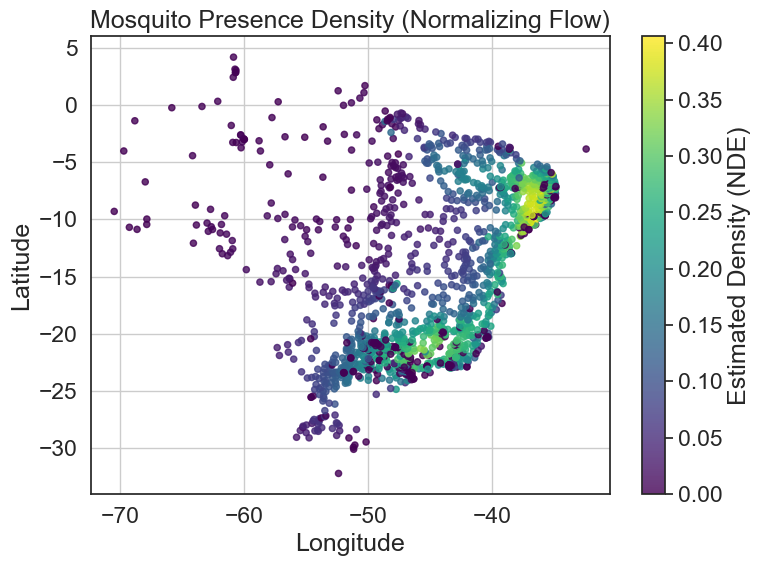

In [660]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Extract all relevant features from nodata
nodata_features = nodata[feature_cols].values

# Split into target and covariate features
nodata_target = nodata_features[:, target_indices]  
nodata_covariates = nodata_features[:, covariate_indices] 

# Normalize the data 
nodata_target = target_scaler.transform(nodata_target)  
nodata_covariates = covariate_scaler.transform(nodata_covariates)  

# Convert to tensors
nodata_target_tensor = torch.tensor(nodata_target, dtype=torch.float32).to(device)
nodata_covariates_tensor = torch.tensor(nodata_covariates, dtype=torch.float32).to(device)

# Compute log-probabilities 
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(inputs=nodata_target_tensor, context=nodata_covariates_tensor)
    probs = torch.exp(log_probs).cpu().numpy()  


#Add predictions to the nodata 
nodata["nde_prediction"] = probs

#  Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    nodata["X"], nodata["Y"],
    c=nodata["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [661]:
import rasterio
import numpy as np
import os
tif_folder = r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi\2020"

tif_files = sorted([os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith('.tif')])

with rasterio.open(tif_files[0]) as src:
    meta = src.meta.copy()
    annual_data = src.read(1)

for tif in tif_files[1:]:
    with rasterio.open(tif) as src:
        annual_data += src.read(1)

annual_precip_path = "aggregated_2020_precip.tif"
meta.update(dtype=rasterio.float32)

with rasterio.open(annual_precip_path, "w", **meta) as dst:
    dst.write(annual_data.astype(rasterio.float32), 1)

In [662]:
africa_df = extract_raster_values(
    africa_df,
    "aggregated_2020_precip.tif",
    column_name="precipitation_mean"
)

africa_df = extract_raster_values(
    africa_df,
    r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi\gpw_v4_population_density_rev11_2020_30_sec_2020.tif",
    column_name="pop_density"
)

# africa_df = extract_raster_values(
#     africa_df,
#     r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi _temp_water\Complete_TAVG_LatLong1(temperature).nc",
#     column_name=""
# )

africa_df = extract_raster_values(
    africa_df,
    r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi _temp_water\GWP.OSWF.ANNUAL.2020.v1(water_occurrence).tif",
    column_name="water_occurrence"
)







In [663]:
africa_df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,YEAR,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS,precipitation_mean,pop_density,water_occurrence
0,Aedes aegypti,14447,18118,Less than 25km,Less than 25km,7.77,4.57,2011.0,Nigeria,NGA,182,NaN,1197.500000,2348.919434,0
1,Aedes aegypti,14448,18119,point,-999,-4.31,15.19,2011.0,Congo,COG,59,NaN,1702.300049,0.476689,0
2,Aedes aegypti,14449,18119,point,-999,-4.26,15.20,2011.0,Congo,COG,59,NaN,1725.699951,0.476689,0
3,Aedes aegypti,14474,18131,point,-999,4.37,18.55,2010.0,Central African Republic,CAF,49,NaN,1416.899902,27038.519531,0
4,Aedes aegypti,14475,18131,Less than 100km,Less than 100km,5.05,21.20,2010.0,Central African Republic,CAF,49,NaN,1498.099976,404.273468,0


In [664]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Clean Africa data 
required_cols = ["X", "Y", "pop_density", "precipitation_mean","water_occurrence"]
africa_clean = africa_df.dropna(subset=required_cols).copy()

# Extract and scale covariates and targets
X_cov_africa = africa_clean[["pop_density", "precipitation_mean","water_occurrence"]].values
X_tgt_africa = africa_clean[["X", "Y"]].values

X_cov_scaled = scaler.fit_transform(X_cov_africa)
X_tgt_scaled = scaler.fit_transform(X_tgt_africa)

X_cov_tensor = torch.tensor(X_cov_scaled, dtype=torch.float32).to(device)
X_tgt_tensor = torch.tensor(X_tgt_scaled, dtype=torch.float32).to(device)

# Predict using trained flow
flow.eval()
with torch.no_grad():
    log_prob = flow.log_prob(inputs=X_tgt_tensor, context=X_cov_tensor).cpu().numpy()

# Normalize prediction for visualization
suitability = (log_prob - log_prob.min()) / (log_prob.max() - log_prob.min())
africa_clean["suitability"] = suitability


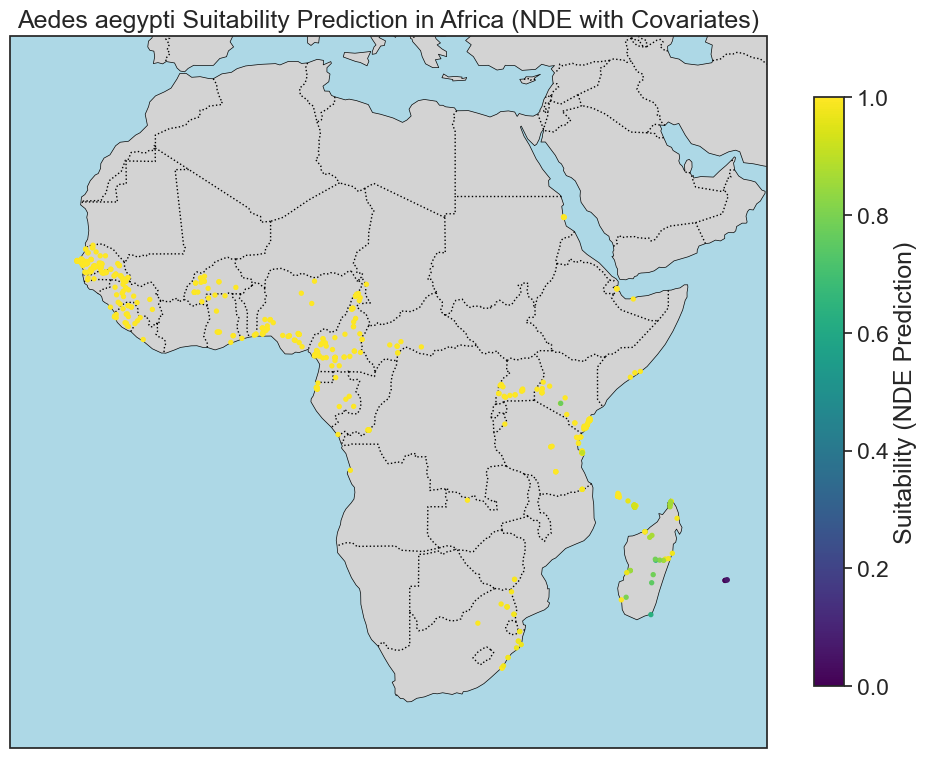

In [665]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], crs=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=2)

# Plot predicted suitability
scatter = ax.scatter(
    africa_clean["X"],
    africa_clean["Y"],
    c=africa_clean["suitability"],
    cmap="viridis",
    s=8,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Colorbar and title
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", shrink=0.8)
cbar.set_label("Suitability (NDE Prediction)")

ax.set_title("Aedes aegypti Suitability Prediction in Africa (NDE with Covariates)")
plt.tight_layout()
plt.show()




### Why Extrapolation with Covariates Is Difficult

When conditioning a model on environmental covariates, it's essential that the covariate values at inference time fall within the range and structure of the data seen during training.

In this case:

* Training data contains covariates like:

  * `pop_density` mostly under 20,000
  * `precipitation_mean` typically below 8
  * `water_occurrence` either 0 or low values

* Africa-wide inference data ontains:

  * `pop_density` values spanning from near 0 up to 27,000+
  * `precipitation_mean` values that may look reasonable
  * But `water_occurrence` is almost always zero

This means:

### The combination of covariates during inference does not align well with what the model saw during training.

* Even if individual variables are within range, their joint distribution  may be novel
* This is known as covariate shift or distributional mismatch
* Normalizing flows, like most machine learning models, struggle with extrapolating to such unseen combinations


### Key Implication

The model isn't necessarily saying "this area is unsuitable" itin essence it is saying "I don't know this kind of environment, so I cannot assign confident suitability."


### Solutions or Workarounds

* Use more diverse training data (e.g. more locations across different covariate regimes)
* Reduce reliance on covariates that are highly biased or zero-dominated (like `water_occurrence`)
* Consider dimensionality reduction or covariate selection to keep only informative variables



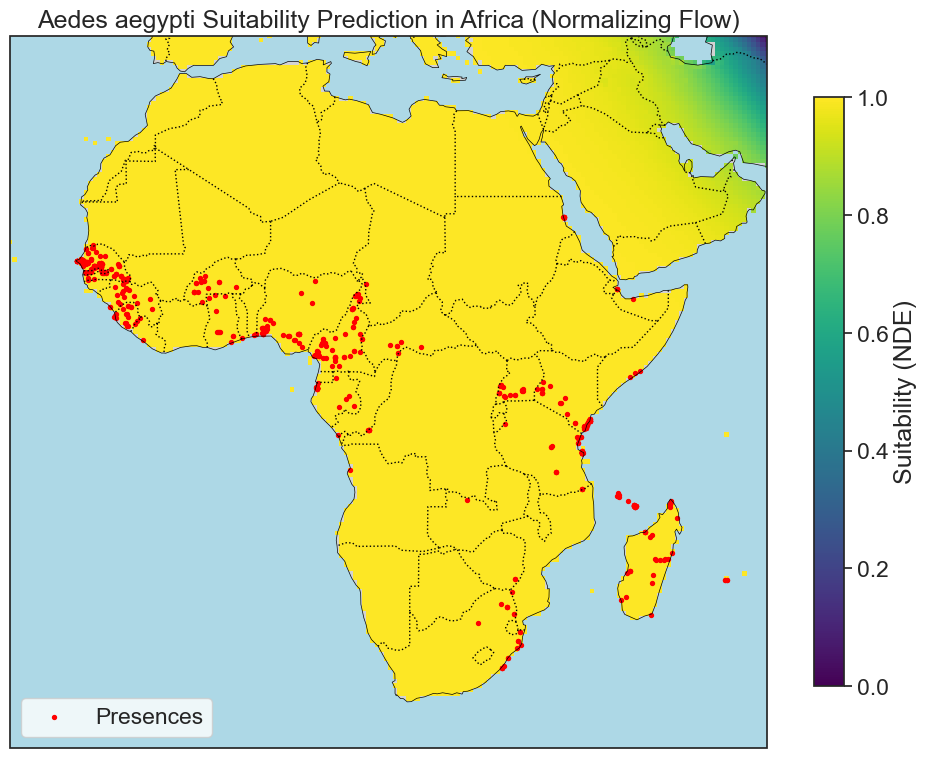

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Generate grid
lon_vals = np.linspace(-25, 60, 170)
lat_vals = np.linspace(-40, 40, 160)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
grid_df = pd.DataFrame({
    "X": lon_grid.ravel(),
    "Y": lat_grid.ravel()
})

# Extract covariates from raster
grid_df = extract_raster_values(grid_df, "aggregated_2020_precip.tif", "precipitation_mean")
grid_df = extract_raster_values(grid_df, r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi\gpw_v4_population_density_rev11_2020_30_sec_2020.tif", "pop_density")
grid_df = extract_raster_values(grid_df, r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi _temp_water\GWP.OSWF.ANNUAL.2020.v1(water_occurrence).tif", "water_occurrence")

# Drop missing data
grid_df = grid_df.dropna()

# Normalize using training scalers
X_cov = grid_df[["pop_density", "precipitation_mean", "water_occurrence"]].values
X_tgt = grid_df[["X", "Y"]].values

X_cov_scaled = covariate_scaler.transform(X_cov)
X_tgt_scaled = target_scaler.transform(X_tgt)

X_cov_tensor = torch.tensor(X_cov_scaled, dtype=torch.float32).to(device)
X_tgt_tensor = torch.tensor(X_tgt_scaled, dtype=torch.float32).to(device)

# Predict log-probability with context
flow.eval()
with torch.no_grad():
    logp = flow.log_prob(inputs=X_tgt_tensor, context=X_cov_tensor).cpu().numpy()

# Normalize and reshape
suitability = (logp - logp.min()) / (logp.max() - logp.min())
grid_df["suitability"] = suitability

# Recreate grid for plotting
Z = np.full(lon_grid.shape, np.nan)
for x, y, s in grid_df[["X", "Y", "suitability"]].itertuples(index=False, name=None):
    xi = np.where(np.isclose(lon_vals, x))[0]
    yi = np.where(np.isclose(lat_vals, y))[0]
    if xi.size > 0 and yi.size > 0:
        Z[yi[0], xi[0]] = s

# Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=":")

mesh = ax.pcolormesh(
    lon_grid,
    lat_grid,
    Z,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto"
)

# Add presence points
ax.scatter(
    africa_df["X"], africa_df["Y"],
    color="red", s=8,
    transform=ccrs.PlateCarree(),
    label="Presences"
)

plt.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.8, label="Suitability (NDE)")
ax.set_title("Aedes aegypti Suitability Prediction in Africa (Normalizing Flow)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()
